# CatBoost Model

In [33]:
import numpy as np
import pandas as pd

In [34]:
train = pd.read_csv('data/train.csv')
predict = pd.read_csv('data/test.csv')

In [35]:
passenger_id = predict[['id']].copy()

In [36]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [37]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75000,374999.50000,562499.25000,749999.00
Episode_Length_minutes,662907.0,64.504738,32.969603,0.0,35.73000,63.84000,94.07000,325.24
Host_Popularity_percentage,750000.0,59.859901,22.873098,1.3,39.41000,60.05000,79.53000,119.46
Guest_Popularity_percentage,603970.0,52.236449,28.451241,0.0,28.38000,53.58000,76.60000,119.91
Number_of_Ads,749999.0,1.348855,1.151130,0.0,0.00000,1.00000,2.00000,103.91
Listening_Time_minutes,750000.0,45.437406,27.138306,0.0,23.17835,43.37946,64.81158,119.97


In [38]:
predict.isnull().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [39]:
train.isnull().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [41]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [42]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Preprocessing of data

In [43]:
def create_features(df):
    #df[['Episode_Name','Episode_Num']] = df['Episode_Title'].str.split(' ', expand=True)
    #f['Episode_Num'] = df['Episode_Num'].astype(int)

    # ジャンルごとにホストの人気度の平均を計算して，それを辞書型に変換
    #genre_to_weight = df.groupby('Genre')['Host_Popularity_percentage'].mean().to_dict()
    #df['Host_Popularity_by_Genre'] =  df['Host_Popularity_percentage'] * df['Genre'].map(genre_to_weight)
    """
    # 広告数とホスト人気の関係    
    ads_to_weight = df.groupby('Number_of_Ads')['Host_Popularity_percentage'].mean().to_dict()
    df['Host_Popularity_by_Ads'] =  df['Host_Popularity_percentage'] * df['Number_of_Ads'].map(ads_to_weight)

    # ホストの人気 ＊ エピソードの長さ
    df['Host_Popularity_by_Episode_Length'] = df['Host_Popularity_percentage'] * df['Episode_Length_minutes']

    # ホスト人気 * ゲスト人気
    df['Host_Guest_Popularity'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    
    # 視聴時間の長さ / 広告数
    ads_to_weight = df.groupby('Number_of_Ads')['Episode_Length_minutes'].mean().to_dict()
    df['Episode_Ads'] =  df['Episode_Length_minutes'] / df['Number_of_Ads'].map(ads_to_weight)
    """
    
    # ホスト人気 * ゲスト人気
    #df['Host_Guest_Popularity'] = df['Host_Popularity_percentage'] * df['Guest_Popularity_percentage']
    return df

train = create_features(train)
predict = create_features(predict)

# 異常値処理

In [44]:
def clean_abnormal_values(df):
    
    # 100%以上はクリップ（`.loc` を使って変更）
    df.loc[:, 'Host_Popularity_percentage'] = df['Host_Popularity_percentage'].clip(upper=100)
    df.loc[:, 'Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].clip(upper=100)

    df.loc[:, 'Episode_Length_minutes'] = df['Episode_Length_minutes'].clip(upper=125)
    df.loc[:, 'Number_of_Ads'] = df['Number_of_Ads'].clip(upper=12)
    
    return df

# train と predict に適用
train = clean_abnormal_values(train)
predict = clean_abnormal_values(predict)
train['Number_of_Ads'] = train['Number_of_Ads'].fillna(train['Number_of_Ads'].mean())

In [45]:
""" ロバストスケーリング
from sklearn.preprocessing import RobustScaler

def normalize_data(df):
    scaler = RobustScaler()
    # スケーリングを行うカラムを指定
    columns_to_scale = ['Episode_Length_minutes', 'Number_of_Ads']
    
    # スケーリングを実行
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df

train = normalize_data(train)
predict = normalize_data(predict)
#"""


" ロバストスケーリング\nfrom sklearn.preprocessing import RobustScaler\n\ndef normalize_data(df):\n    scaler = RobustScaler()\n    # スケーリングを行うカラムを指定\n    columns_to_scale = ['Episode_Length_minutes', 'Number_of_Ads']\n\n    # スケーリングを実行\n    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])\n\n    return df\n\ntrain = normalize_data(train)\npredict = normalize_data(predict)\n#"

In [46]:
# columns to drop 
def delete_columns(df):
    df.drop(columns=['id'], inplace=True)
    return df

train = delete_columns(train)
predict = delete_columns(predict)

In [47]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


# Data preparation before modeling

### Since there are few tpyes of object data,label encoding will be applied


In [48]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

def label_enocding(df,columns):
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

encoding_cols = ['Podcast_Name','Genre','Publication_Day',
                 'Publication_Time','Episode_Sentiment','Episode_Title']

train = label_enocding(train, encoding_cols)
predict = label_enocding(predict, encoding_cols)


In [49]:
train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,34,98,NaN,9,74.81,4,3,NaN,0.0,2,31.41998
1,24,19,119.80,1,66.95,2,0,75.95,2.0,0,88.01241
2,40,8,73.90,2,69.97,5,1,8.97,0.0,0,44.92531
3,10,40,67.17,8,57.22,1,2,78.70,2.0,2,46.27824
4,31,85,110.51,3,80.07,1,0,58.68,3.0,1,75.61031


In [50]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['Listening_Time_minutes'])
    y = df['Listening_Time_minutes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)
predict_X = predict.copy()

# Model Construction

In [51]:
import catboost as cb

# CatBoostモデルの構築（回帰タスク用）
def build_catboost_model(iterations=100, depth=5, learning_rate=0.1):
    """CatBoost回帰モデルを構築する関数"""
    model = cb.CatBoostRegressor(
        iterations=iterations,         # 決定木の数
        depth=depth,                   # 決定木の深さ
        learning_rate=learning_rate,   # 学習率（小さいほど安定性は向上するが、収束が遅くなる）
        loss_function='RMSE',          # 回帰タスクに適した損失関数（平均二乗誤差の平方根）
        random_seed=42,                # 乱数シード（結果の再現性のため）
        verbose=100                    # 学習ログの表示間隔
    )
    return model

# モデルの構築
catboost_model = build_catboost_model()

0:	learn: 25.2281921	total: 21.9ms	remaining: 2.17s
99:	learn: 13.1706563	total: 1.33s	remaining: 0us


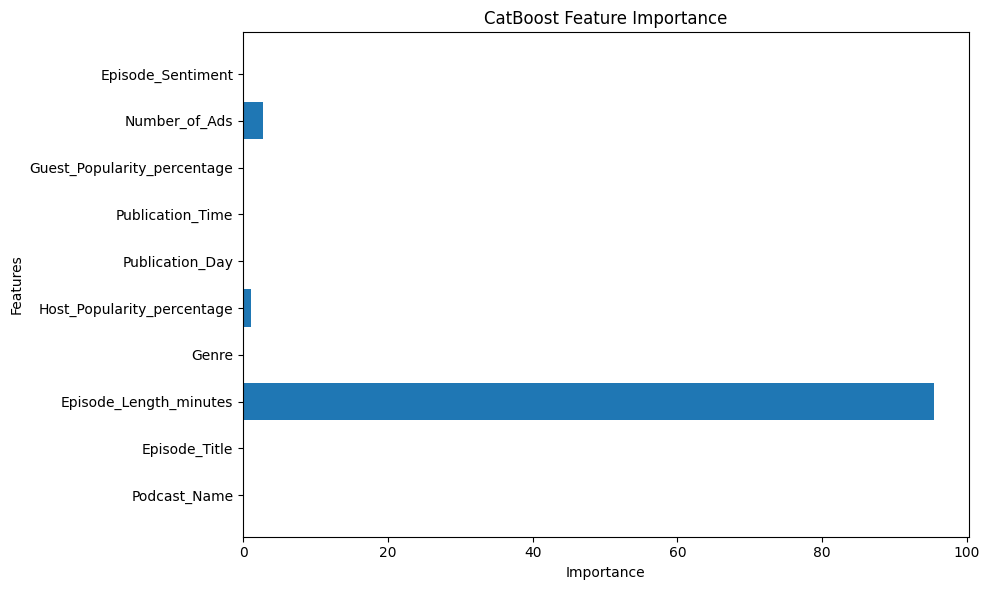

In [52]:
import matplotlib.pyplot as plt

# Train CatBoost model
catboost_model.fit(X_train, y_train,verbose=100)

# feature importance
importances = catboost_model.get_feature_importance()
feature_nmaes = X_train.columns

# plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_nmaes, importances)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Model evalution

In [53]:
xgb_pred = catboost_model.predict(X_test)

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_metrics(y_true,y_pred):
    
    results = []

    def calulate_metrics(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        return {
            'MSE': mse,
            'RMSE': mae,
            'R2': r2
        }
    results.append(calulate_metrics(y_true, y_pred))

    return pd.DataFrame(results)

results = evaluate_metrics(y_test, xgb_pred)
display(results)

,MSE,RMSE,R2
0,172.519917,9.591501,0.765543


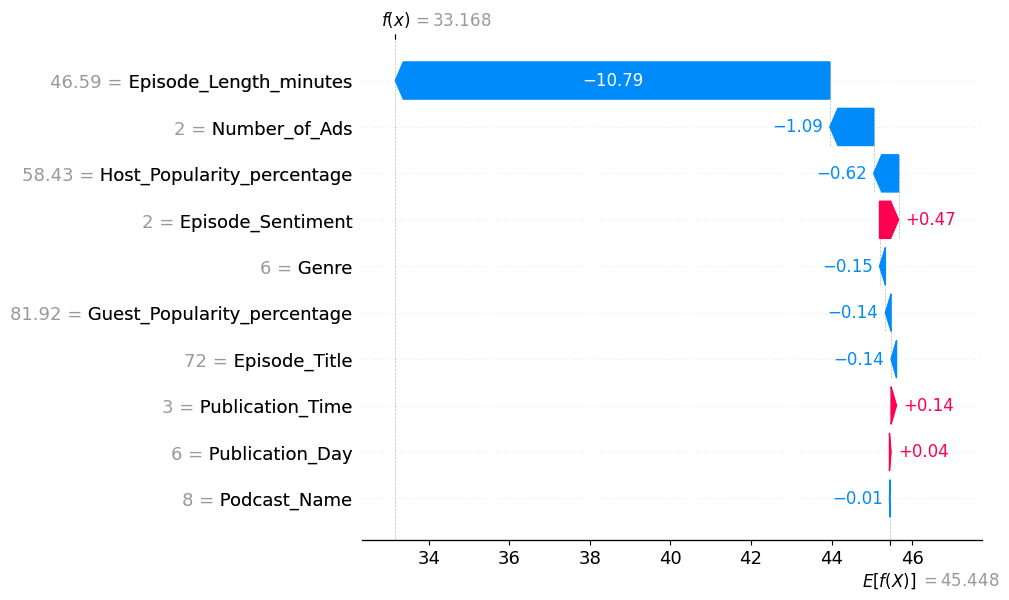

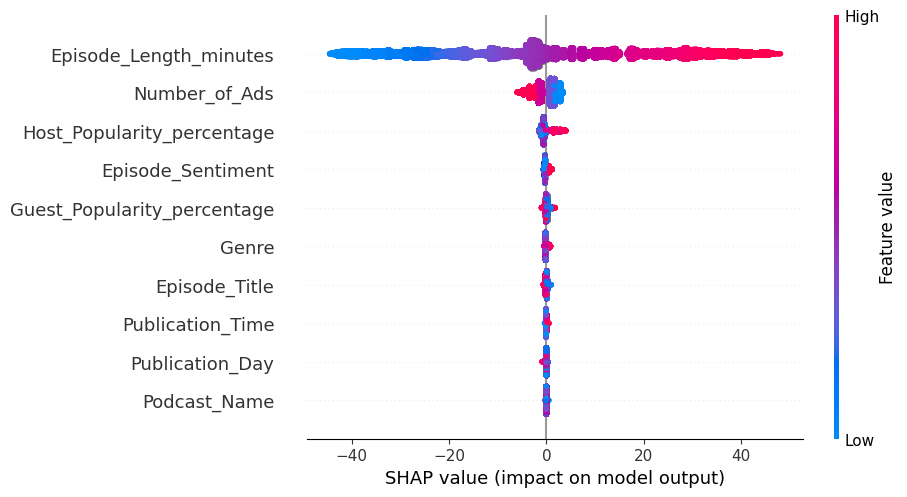

In [55]:
import shap

def explain_model(model):
    # SHAP explainerを作成（TreeExplainerはXGBoostなどに最適）
    explainer = shap.Explainer(model)

    # SHAP値を計算（X_testに対して）
    shap_values = explainer(X_test)

    # 可視化（例：1件目の予測理由）
    shap.plots.waterfall(shap_values[0])

    # 全体の特徴量の影響（要約プロット）
    shap.plots.beeswarm(shap_values)

explain_model(catboost_model)


# Optuna

In [56]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def optimize_catboost(trial):
    params = {
        # 決定木（ツリー）の数。XGBoostのn_estimatorsに相当
        'iterations': trial.suggest_int('iterations', 50, 500),
        # 木の深さ（複雑さ）
        'depth': trial.suggest_int('depth', 3, 10),
        # 学習率
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        # L2正則化係数。XGBoostのmin_child_weightに近い役割
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        # カテゴリ変数の分割で使用する閾値の候補の数
        'border_count': trial.suggest_int('border_count', 32, 255),
        # 回帰タスク向け損失関数としてRMSEを指定
        'loss_function': 'RMSE',
        # 乱数シード
        'random_seed': 42
    }
    
    # ログ出力を抑えるためにverbose=0とする
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

# 最適化の実行（n_trials=10は例。実際の問題に合わせて調整してください）
study = optuna.create_study(direction='minimize')
study.optimize(optimize_catboost, n_trials=100)

# 最良結果の表示
print('Best trial:')
trial = study.best_trial
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 最適なパラメータを用いて再学習
optimized_catboost = CatBoostRegressor(**trial.params, random_seed=42, verbose=100)
optimized_catboost.fit(X_train, y_train)


[I 2025-04-21 11:25:26,020] A new study created in memory with name: no-name-64527026-bb9e-4cb5-926e-4fd8da161be0
[I 2025-04-21 11:25:30,171] Trial 0 finished with value: 170.3193362272763 and parameters: {'iterations': 387, 'depth': 4, 'learning_rate': 0.24439250234912677, 'l2_leaf_reg': 3.762607920752059, 'border_count': 119}. Best is trial 0 with value: 170.3193362272763.
[I 2025-04-21 11:25:40,288] Trial 1 finished with value: 168.86244837505765 and parameters: {'iterations': 444, 'depth': 10, 'learning_rate': 0.2566123296678441, 'l2_leaf_reg': 6.859430907846602, 'border_count': 213}. Best is trial 1 with value: 168.86244837505765.
[I 2025-04-21 11:25:45,749] Trial 2 finished with value: 169.37121955931653 and parameters: {'iterations': 310, 'depth': 9, 'learning_rate': 0.28548557059615803, 'l2_leaf_reg': 3.870897753256849, 'border_count': 117}. Best is trial 1 with value: 168.86244837505765.
[I 2025-04-21 11:25:50,215] Trial 3 finished with value: 170.78404550879682 and parameters

Best trial:
  MSE: 167.9980112988101
  Params: 
    iterations: 468
    depth: 10
    learning_rate: 0.15808021820578141
    l2_leaf_reg: 7.772643090454583
    border_count: 202
0:	learn: 24.0290973	total: 21.6ms	remaining: 10.1s
100:	learn: 12.9478245	total: 2.16s	remaining: 7.86s
200:	learn: 12.7227480	total: 4.38s	remaining: 5.82s
300:	learn: 12.5323909	total: 6.63s	remaining: 3.68s
400:	learn: 12.3654969	total: 8.79s	remaining: 1.47s
467:	learn: 12.2663129	total: 10.2s	remaining: 0us


In [57]:
optimized_pred = optimized_catboost.predict(X_test)
optimized_metrics = evaluate_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,RMSE,R2
0,167.998011,9.427415,0.771688


In [58]:
# モデルの保存（拡張子は .cbm が一般的） 13.24730を保存
#optimized_catboost.save_model("model/catboost/catboost_model_1.cbm")

"""
from catboost import CatBoostRegressor

# モデルの読み込み
catboost_model = CatBoostRegressor()
catboost_model.load_model("model/catboost/catboost_model.cbm")
#"""

'\nfrom catboost import CatBoostRegressor\n\n# モデルの読み込み\ncatboost_model = CatBoostRegressor()\ncatboost_model.load_model("model/catboost/catboost_model.cbm")\n#'

In [59]:
Predict_y = catboost_model.predict(predict_X)

In [60]:
predict_X

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,11,71,78.96,2,38.11,2,1,53.33,1.0,1
1,36,16,27.87,5,71.29,3,2,NaN,0.0,1
2,24,3,69.10,1,67.89,0,1,97.51,0.0,2
3,4,71,115.39,1,23.40,3,2,51.75,2.0,2
4,27,46,72.32,4,58.10,6,2,11.30,2.0,1
...,...,...,...,...,...,...,...,...,...,...
249995,31,2,21.05,3,65.77,2,1,96.40,3.0,0
249996,24,84,85.50,1,41.47,2,3,30.52,2.0,0
249997,24,60,12.11,1,25.92,4,1,73.69,1.0,1
249998,29,41,113.46,0,43.47,0,3,93.59,3.0,2


In [61]:
predict_df = pd.DataFrame(Predict_y, columns=['Listening_Time_minutes'])

submission = pd.concat([passenger_id, predict_df], axis=1)

display(submission.head())

,id,Listening_Time_minutes
0,750000,56.726343
1,750001,17.899176
2,750002,51.009192
3,750003,80.926480
4,750004,48.359360


In [63]:
submission.to_csv('submit/cat_submit/catboost4.csv', index=False)